# **GOLEM MFR tomography**
This notebook loads the camera data from two certical and radial fast cameras on tokamak GOLEM and then performs tomopgraphic inversion using MFR algorithm.
Geometry matrix data are needed - notebook called geometry_matrix.ipynb creates all needed.
 

*Required python libraries for this notebook: numpy, matplotlib,, opencv, tomotok, IPython.display and scipy.ndimage*
________________________________________________

# Code:
Necessary imports:

In [1]:
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np
import cv2 #opencv
import requests
import os, glob
from pathlib import Path

from tomotok.core.derivative import compute_iso_dmats, compute_aniso_dmats
from tomotok.core.geometry import RegularGrid
from tomotok.core.geometry.io import load_sparse_gmat
from tomotok.core.inversions import CholmodMfr, Mfr, Fixt, CholmodFixt
from scipy.ndimage import gaussian_filter

from IPython.display import Image


In [2]:
shot_no = 45940
FPS = 40000 #camera frame rate
FPMS = FPS * 1e-3 #camera frame rate [1/ms]

result_folder = Path("./results")
Path(result_folder).mkdir(exist_ok=True)
Path(result_folder / "data").mkdir(exist_ok=True)
Path(result_folder / "graphs").mkdir(exist_ok=True)
Path(result_folder / "stats").mkdir(exist_ok=True)

frames_folder = Path("./frames")
Path(frames_folder).mkdir(exist_ok=True)
Path(frames_folder / "vertical").mkdir(exist_ok=True)
Path(frames_folder / "radial").mkdir(exist_ok=True)

### **Defined functions:**
Function creates mask for poloidal plane dataset:

In [3]:
def create_mask(grid: RegularGrid, limiter_mask: bool, plasmaradius: Optional[float] = None):
    """Creates mask, of the same size as grid, of True and False vlaues to define where to compute the reconstructions.

    Args:
        grid (RegularGrid): Reconstruction grid.
        limiter_mask (bool): True if you want the results up to limiter, False if you want to see results to LCFS.
        plasmaradius (float, optional): Radius of plasma (and of the reconstruction domain). If limiter_mask is False, this parameter can be None.

    Returns:
        RegularGrid class ndarray of the given grid size, with True values where the reconstrucition will be computed (inside limiter/plasma radius).
    """
    
    plasmacentre = 0.40 #minor tokamak radius
    chamberradius = 0.1 #chamber radius
    
    #Limiter and chamber radii definitions
    t = np.linspace(0,2*np.pi,100) #t is just a parameter for the curves/circles

    if limiter_mask==True:
        #limiter curve definition
        r = plasmacentre + plasmaradius*np.sin(t)
        z = plasmaradius*np.cos(t)
        bdm = grid.is_inside(r, z)
    else:
        #chamber curve definition
        R = plasmacentre + chamberradius*np.sin(t)
        Z = chamberradius*np.cos(t)
        bdm = grid.is_inside(R, Z)
    return bdm

Function that extracts images from loaded video data:

In [4]:
def imagesfromvideo(minrange:int,maxrange:int):
    """Extracts single frames from both GOLEM camera data and saves them

    Args:
        ver_vid (cv2.VideoCapture): vertical camera data
        rad_vid (cv2.VideoCapture): radial camera data
    Returns:
    """
    #loads from golem shot website - .mp4
    capver=cv2.VideoCapture(f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/FastCameras/Camera_Vertical/Data.mp4')
    caprad=cv2.VideoCapture(f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/FastCameras/Camera_Radial/Data.mp4')
    i = minrange 
    
    capver.set(1,i)
    caprad.set(1,i)
    
    retver, framever = capver.read(1) 
    retrad, framerad = caprad.read(1)     
    while retver and retrad and i < maxrange:
        retver, framever = capver.read(1) 
        retrad, framerad = caprad.read(1) 
        
        #Saving frames
        namever = str(frames_folder / "vertical" / str(str(i)+'.png'))
        cv2.imwrite(namever, framever) 
        namerad = str(frames_folder / "radial" / str(str(i)+'.png'))
        cv2.imwrite(namerad, framerad) 
        i=i+1
    capver.release()
    caprad.release()

In [5]:
def datafromimage(framenumber:int,channel: int):
    """Extracts signal (frame given by frame number) from both GOLEM camera frames. 

    Args:
        framenumber (int): Number of frame which will be extracted
        channel (int): color channel to be used 012 BGR


    Returns:
        sig: Signal from given frame in ndarray form.
    """
    namever = str(frames_folder / "vertical" / str(str(framenumber)+'.png'))
    namerad = str(frames_folder / "radial" / str(str(framenumber)+'.png'))

    ogimagerad = cv2.imread(namerad,cv2.IMREAD_UNCHANGED )[:,:,channel] #loading radial image 
    ogimagever = cv2.imread(namever,cv2.IMREAD_UNCHANGED )[:,:,channel] #loading vertical image

    #THIS MUST BE CHANGED DEPENDING ON THE GEOMETRY MATRIX USED - MUST CONSTRUCT IT FOR EACH ROW DIFFERENTLTY
    rowrad = 511 #which radial camera detector row to use for reconstruction
    rowver = 511 #which vertical camera detector row to use for reconstruction

    #Discarding obstructed detectors
    leftstoprad = 0 #leftmost R camera detector to be used (useful if cameras' view is obstructed on edges, 0 if all detectors see the plasma)
    rightstoprad = 1280 #rightmost R camera detector to be used (1280 if all)
    totalspanrad = rightstoprad - leftstoprad

    leftstopver = 0 #leftmost V camera detector to be used (useful if cameras' view is obstructed on edges, 0 if all detectors see the plasma)
    rightstopver = 1280 #rightmost V camera  detector to be used (1280 if all)
    totalspanver = rightstopver - leftstopver

    fullheight = 1024 #height of full camera picture in pixels
    fullwidth = 1280 #width of full camera picture in pixels
    imgheight = np.shape(ogimagerad)[0] #height of loaded image, 
    imgheighthalf = int((fullheight-imgheight)/2) #where to insert loaded image into 1024 by 1280 array for easier handling of distortion

    
    imagerad = np.zeros((fullheight-imgheight, fullwidth))
    imagever = np.zeros((fullheight-imgheight, fullwidth))
    imagerad = np.insert(imagerad, imgheighthalf, ogimagerad, axis=0)
    imagever = np.insert(imagever, imgheighthalf, ogimagever, axis=0)
    
    #imagever = np.flip(imagever)
    #imagerad = np.flip(imagerad)

    imagerad = imagerad[rowrad:rowrad+1,leftstoprad:rightstoprad] #taking signal from only one row of camera detectors
    imagever = imagever[rowver:rowver+1,leftstopver:rightstopver]
    imagever = np.squeeze(imagever,axis=0)
    imagerad = np.squeeze(imagerad,axis=0)
    
    
    sig = np.concatenate((imagever, imagerad), axis=0)
    
    return sig

Function where the tomographic inversion is performed:

In [6]:
def datasolve(framenumber: int, sig, grid, magflux, mask, fixed:bool, alpha=[0.7,0.7,0.7]):
    """ Tomographic reconstruction using MFR of single frame data, which saves result

    Args:
        framenumber (int): framenumber
        sig (_type_): camera signal to be reconstructed, most likely from datafromimage()
        grid (_type_): reconstruction grid
        magflux (_type_): magnetic flux surfaces
        mask (_type_):  mask for the reconstruction grid, reconstruction only within limiter right now 
        fixed (bool): if the function should use the fixed parameter set True (could speed up the reconstruction)

    Returns:
        _type_: np.ndarray of reconstructed plane
    """     
    
    data = sig.reshape(1, -1)  # data should have shape (#timeslices, #channels/pixels)
    
    errors = .02*data + 10 #error estimation. This works, but should be improved and studied further. Has very large impact on results

    # dmats = compute_iso_dmats(grid)
    dmats = compute_aniso_dmats(grid, magflux=magflux, mask=mask) #derivative matrix with mask
    gmat_sel = gmat[:, bdm.flatten()] #geometric matrix with mask

    aniso = 2 #parameter dictating anisotropy of smoothing perp/parallel to mag flux surfaces

    if fixed == True:
        
        #Solver that uses a fixed regularization parameter and is therefore faster (about 10 times). 
        try:
            solver = CholmodFixt()
        except ImportError:
            solver = Fixt()
            
        res, chi = solver(data, gmat_sel, dmats, errors, aniso=aniso,parameters = alpha)
    else: 
        #Solvers that use full Minimum Fischer Regularization. Slower but "better".
        try: 
            solver = CholmodMfr()  # requires scikit.sparse
        except ImportError:
            solver = Mfr()  # slowlier version based on scipy.sparse

        res, chi = solver(data, gmat_sel, dmats, errors, aniso=aniso)
        #print('last reg parameter logalpha = {:.2f}'.format(chi[-1]['logalpha'][-1]))



    #reshaping result to original grid shape
    res2 = np.zeros((1, grid.shape[0]*grid.shape[1]))
    res2[0, bdm.flatten()] = res
    res2 = res2.reshape(1, *grid.shape)
    np.save(result_folder / 'data' / str("res_"+ str(framenumber)), res2, allow_pickle=True, fix_imports=True)
    np.save(result_folder / 'stats' / str("stats_"+ str(framenumber)), chi, allow_pickle=True, fix_imports=True)
    return res2, chi



### **Main part of the code:**
Here some parameters are defined, like plasma radius etc. to set boundaries for example

In [7]:
# Define some "parameters" used in tokamak GOLEM

#Parameters:
plasmaradius=0.085 #Radius of plasma (and of the reconstruction domain), 0.085 for limiter. 
padding = 0.015 #padding to work with slightly bigger grid for better visualization
#GOLEM parameters:
chamberradius = 0.1 #chamber radius
plasmacentre = 0.40 #minor tokamak radius

#Curves for limiter contures etc.:
t = np.linspace(0,2*np.pi,100) #t is just a parameter for the curves/circles
#Plasma (determined by limiter)
r = plasmacentre + plasmaradius*np.sin(t)
z = plasmaradius*np.cos(t)
#Chamber wall
R = plasmacentre + chamberradius*np.sin(t)
Z = chamberradius*np.cos(t)

#Grid minimum and maximum locations in poloidal plane of the GOLEM tokamak for better plotting:
gridrmin = plasmacentre - plasmaradius - padding
gridrmax = plasmacentre + plasmaradius + padding
gridzmin = - plasmaradius - padding
gridzmax = plasmaradius + padding


**Load geometry matrix and grid:**

The geometry matrix describes the geometry of the field of view of the cameras in relation to the reconstruction grid. The geometry matrix element [i,j] describes how much the emissivity in the i-th region contributes to the signal at the j-th detector. Here, this is done using the line of sight approximation in which the [i,j] element is proportional to the length of the line of sight of the j-th detector intersecting the i-th region.

The geometry matrix is specific to the cameras used and to the grid size. If any of these are changed, a new geometry matrix has to be generated.

This geometry matrix was created using Tomotok from Calcam camera calibrations. It is specifically for the UX100 color cameras and their 511th pixel row and a 50x50 reconstruction grid. 


In [8]:
# Loading sparse_gmat (class with gmat and grid) and extracting data
gmat_load=load_sparse_gmat('./gmat/gmat_40x40') #loading data
gmat=gmat_load[0] # Defining geometry matrix gmat
grid=gmat_load[1] # Defining grid

A graph showing the cameras' field of view using the sum of geometry matrix elements. 

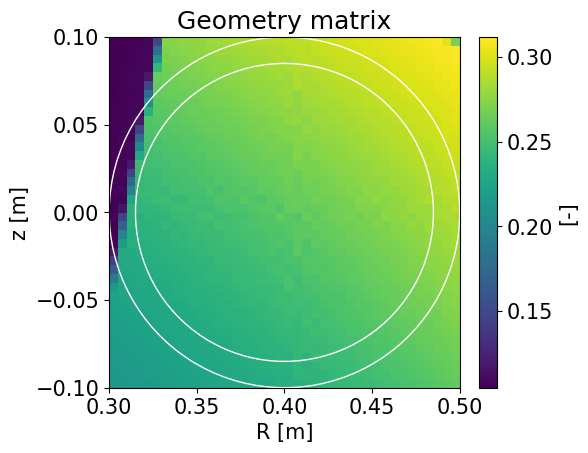

In [9]:
if True: #set True if you want to plot the sum of geometry matrix elements
    plt.rcParams['font.size'] = '15'

    f, a = plt.subplots(figsize=(5,5),dpi=100)
    # img = a.imshow(res.reshape(grid.shape), origin='lower', extent=grid.extent)  # nodes must be squares
    img = a.pcolorfast(grid.r_border, grid.z_border, gmat.toarray().sum(0).reshape(grid.shape))
    plt.plot(r,z, 'w', lw=1)
    plt.plot(R,Z, 'w', lw=1)
    a.set_aspect(1)
    a.set_xlabel('R [m]')
    a.set_ylabel('z [m]')

    plt.title('Geometry matrix')

    plt.xticks([gridrmin,gridrmax,0.4,0.45,0.35])
    plt.yticks([gridzmin,gridzmax,0.,0.05,-0.05])
    #plt.xticks(rotation = 90)

    cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
    cbar.ax.set_ylabel('[-]')

    imagename='geometric_matrix.png'
    plt.savefig(imagename,bbox_inches="tight")

**Create mask:**

The mask is created to limit the reconstruction domain to only the inside of the tokamak chamber. 

In [10]:
# Calling mask function for defined grid
bdm=create_mask(grid, limiter_mask=False, plasmaradius=plasmaradius)

In [11]:
if False: #set True if you want to plot the mask
    plt.figure()
    plt.imshow(bdm)

**Generating Psi:**

The magnetic surfaces are used for anisotropical smoothing of the results. 

Currently, the Solovyev solution of the Grad-Shafranov equation is used.

In [12]:
#Psi generation
nr = grid.nr
nz = grid.nz
span = plasmaradius+padding
offsetx = 0.01 #offset of centre in x direction 
offsety = 0 #offset of centre in y direction 
x = np.linspace(-span, span, nr)
y = np.linspace(-span, span, nz)
mx, my = np.meshgrid(x, y)

#Simplest possible Psi - concentric circles
#ipsi = np.sqrt((mx -offsetx)*( mx-offsetx) + (my-offsety) *(my-offsety))

#Simplest ~physical Psi - Solovyev solution of G-S equation
R0 = 0.4
a = 0.085
eps = a/R0
tau = 1
sigma = 1
ipsi = ( ((mx)/a) - (eps/2)*(1-((mx)/a)**2))**2 + (1-eps**2/4)*(my/a)**2


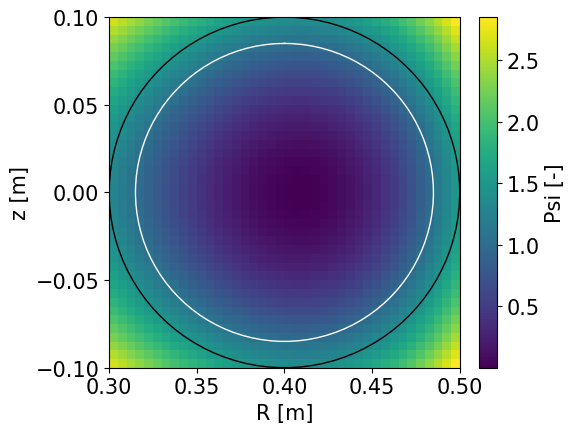

In [13]:
if True: #set True if you want to plot the "Psi" - smoothing of the result
    plt.rcParams['font.size'] = '15'
    f, a = plt.subplots(figsize=(5,5),dpi=100)
    # img = a.imshow(res.reshape(grid.shape), origin='lower', extent=grid.extent)  # nodes must be squares
    img = a.pcolorfast(grid.r_border, grid.z_border, ipsi)
    plt.plot(r,z, 'w', lw=1)
    plt.plot(R,Z, 'k', lw=1)

    a.set_aspect(1)
    a.set_xlabel('R [m]')
    a.set_ylabel('z [m]')

    plt.title('')

    plt.xticks([gridrmin,gridrmax,0.4,0.45,0.35])
    plt.yticks([gridzmin,gridzmax,0.,0.05,-0.05])
    #plt.xticks(rotation = 90)

    cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
    cbar.ax.set_ylabel('Psi [-]')

    imagename='mag_flux.png'
    #plt.savefig(imagename,bbox_inches="tight")

Set the range of frames you want to compute:

In [14]:
#Tomographic reconstructions of all frames selected
plasma_start=float(requests.get(f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/Results/t_plasma_start').text)
plasma_end=float(requests.get(f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/Results/t_plasma_end').text)

minrange = int(plasma_start*FPMS)
maxrange = int(plasma_end*FPMS)+1

imagesfromvideo(minrange,maxrange)


In [15]:
if False:  #set True if you want to test and see the image data
    #Frame numbers to reconstruct
    frame = 278 #starting frame number
    data = datafromimage(frame,0)
    plt.xlabel('Detector number')
    plt.ylabel('Signal')
    plt.plot(data)

Compute and immediately plot all tomography results:

In [16]:
alpha = (0,0,0)

for i in range(minrange,maxrange):
    
    data = datafromimage(i,0)
    
    if i == minrange:
        res, stats = datasolve(i, data, grid, ipsi, bdm,fixed=False)
        logalpha = stats[0]['logalpha']
        alpha = (10**logalpha[0], 10**logalpha[1], 10**logalpha[2])
        chi = stats[0]['chi'][-1]
    else:
        res, stats = datasolve(i, data, grid, ipsi, bdm, fixed=True, alpha = alpha)
        
        chi = stats[0]['chi'][-1]
        if abs(chi - 1) > 0.2:
            res, stats = datasolve(i, data, grid, ipsi, bdm,fixed=False)
            logalpha = stats[0]['logalpha']
            alpha = (10**logalpha[0], 10**logalpha[1], 10**logalpha[2])
            chi = stats[0]['chi'][-1]

    
    plt.figure()
    f, a = plt.subplots(figsize=(5,5),dpi=100)
    img = a.pcolorfast(grid.r_border, grid.z_border, np.load(result_folder / 'data' / str("res_"+ str(i)+ ".npy"), mmap_mode=None, allow_pickle=False, fix_imports=True)[0], snap=True)
    plt.plot(r,z, 'w', lw=2)
    plt.plot(R,Z, 'k', lw=2)
    a.set_aspect(1)
    a.set_xlabel('R [m]')
    a.set_ylabel('z [m]')
    
    time = (i)/FPMS

    plt.title('$t_d$ = '+"{:.3f}".format(time)+' ms')

    plt.xticks([gridrmin,gridrmax,0.4,0.45,0.35])
    plt.yticks([gridzmin,gridzmax,0.,0.05,-0.05])
    #plt.xticks(rotation = 90)

    cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
    cbar.ax.set_ylabel('[-]')

    imagename= result_folder / 'graphs' / str("res_"+ str(i)+ ".png")
    plt.savefig(imagename,bbox_inches="tight",transparent=True)
    plt.close('all')    
    #Magflux based on centre of gravity of previous frame, should be improved
    offsetx = np.sum(res * mx)/np.sum(res)
    offsety = np.sum(res * my)/np.sum(res)
    ipsi = np.sqrt((mx -offsetx)*( mx-offsetx) + (my-offsety) *(my-offsety))

last chi^2 = 0.3120, time: 11.66 s
last chi^2 = 0.4422, time: 0.87 s
last chi^2 = 0.2423, time: 11.22 s
last chi^2 = 0.2814, time: 0.83 s
last chi^2 = 0.2608, time: 11.09 s


Replot all results with the same color scale:

In [17]:
#Plot all reconstructions

#Finding maximum in all results_iso - to have a stationary colorbar
maxres= 0
for i in range(minrange,maxrange):
    res2 = np.load(result_folder / 'data' / str("res_"+ str(i)+ ".npy"), mmap_mode=None, allow_pickle=True, fix_imports=True)
    maxres = max(maxres, np.max(res2))
        
plt.rcParams['font.size'] = '15'

for i in range(minrange,maxrange):
    f, a = plt.subplots(figsize=(5,5),dpi=100)
    img = a.pcolorfast(grid.r_border, grid.z_border, np.load(result_folder / 'data' / str("res_"+ str(i)+ ".npy"), mmap_mode=None, allow_pickle=True, fix_imports=True)[0], vmax=0.5*maxres)
    plt.plot(r,z, 'w', lw=1)
    plt.plot(R,Z, 'k', lw=1)
    a.set_aspect(1)
    a.set_xlabel('R [m]')
    a.set_ylabel('z [m]')
    
    time = (i)/FPMS

    plt.title('$t_d$ = '+"{:.3f}".format(time)+' ms')

    plt.xticks([gridrmin,gridrmax,0.4,0.45,0.35])
    plt.yticks([gridzmin,gridzmax,0.,0.05,-0.05])
    #plt.xticks(rotation = 90)

    cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
    cbar.ax.set_ylabel('[-]')

    imagename=result_folder / 'graphs' / str("res_"+ str(i)+ ".png")
    plt.savefig(imagename,bbox_inches="tight",transparent=True)
    plt.close('all')



Combine all graphs into an animation:

In [18]:

img_array = []

#create iconfig for homepage
i = int(0.5*(maxrange-minrange)+minrange)
img = cv2.imread(str(result_folder / 'graphs' / str("res_"+ str(i)+ ".png")))
cv2.imwrite('tomo_iconfig.png', img) 
cv2.imwrite('tomo_ScreenShotAll.png', img) 

for i in range(minrange,maxrange):
    img = cv2.imread(str(result_folder / 'graphs' / str("res_"+ str(i)+ ".png")))
    img_array.append(img)

size = (np.shape(img)[1],np.shape(img)[0])

out = cv2.VideoWriter('TomographyResult.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()